# Impact of Manufacturing Job Loss on Labor Force Participation Ratek

This notebook was inspired by claims made by a Democratic presidential candidate regarding the impact of manufacturing job loss on the overall labor force participation rate. More specifically, there was a claim that men in particular are dropping out of the labor force due to impact of automation manufacturing jobs.

I found the datasets used here on FRED (https://fred.stlouisfed.org).

Here is a list of the datasets used.

Civilian Labor Force Participation Rate
https://fred.stlouisfed.org/series/LNU01300000

Civilian Labor Force Participation Rate: Men
https://fred.stlouisfed.org/series/LNS11300001

Civilian Labor Force Participation Rate: Women
https://fred.stlouisfed.org/series/LNU01300002

All Employees: Total Nonfarm Payrolls
https://fred.stlouisfed.org/series/PAYEMS

All Employees: Manufacturing
https://fred.stlouisfed.org/series/MANEMP

My goal is to compare changes in the labor force participation rate to changes in the number of employees working in manufacturing.

In [16]:
import sqlite3
import pandas as pd
from datetime import datetime

# Create database connection object
conn = sqlite3.connect('FRED_data.db')


# This function performs processing that is necessary for 
# all the FRED CSV files and then saves the data to DB tables.
# The table_name parameter is used for both the name of the table
# and also for the name of the main column containing the time
# series data
def fred_csv_to_sql(csv_path, table_name, db_conn):
    
    # Read the CSV
    df = pd.read_csv(csv_path)
    
    # Set the column names
    df.columns = ['date', table_name]
    
    # Add a 'year' column based on the existing 'date' column
    df['year'] = df['date'].map(lambda x: pd.to_datetime(x).year)
    
    # Use a pivot table to average the monthly values from
    # the original dataset into yearly values
    df = pd.pivot_table(df, index='year', aggfunc='mean')
    df.reset_index(inplace=True)
    
    # Write the processed data to the database
    df.to_sql(table_name, db_conn, if_exists='replace')
    
    print(df.head(5))



In [17]:
# Pull in the data for the overall labor force participation rate
fred_csv_to_sql('data/Civilian Labor Force Participation Rate.csv', 'labor_force', conn)

   year  labor_force
0  1948    58.808333
1  1949    58.933333
2  1950    59.250000
3  1951    59.283333
4  1952    59.050000


In [18]:
# Pull in the data for the labor force participation rate for men
fred_csv_to_sql('data/Civilian Labor Force Participation Rate - Men.csv', 'labor_force_men', conn)

   year  labor_force_men
0  1948        86.583333
1  1949        86.591667
2  1950        86.250000
3  1951        86.483333
4  1952        86.258333


In [19]:
# Pull in the data for the labor force participation rate for men
fred_csv_to_sql('data/Civilian Labor Force Participation Rate - women.csv', 'labor_force_women', conn)

   year  labor_force_women
0  1948          32.666667
1  1949          33.133333
2  1950          33.850000
3  1951          34.641667
4  1952          34.700000


In [20]:
# Query the data with a JOINs to show all the time series in one table
lfpr = pd.read_sql_query("""
    SELECT 
        lf.year,
        lf.labor_force AS "Total Labor Force Participation Rate (LFPR)",
        lfm.labor_force_men AS "LFPR - Men",
        lfw.labor_force_women AS "LFPR - Women"
    FROM labor_force AS lf
    INNER JOIN labor_force_men AS lfm ON lf.year=lfm.year
    INNER JOIN labor_force_women AS lfw ON lf.year=lfw.year
""", conn)

lfpr.head(10)

,year,Total Labor Force Participation Rate (LFPR),LFPR - Men,LFPR - Women
0,1948,58.808333,86.583333,32.666667
1,1949,58.933333,86.591667,33.133333
2,1950,59.250000,86.250000,33.850000
3,1951,59.283333,86.483333,34.641667
4,1952,59.050000,86.258333,34.700000
5,1953,58.850000,86.008333,34.400000
6,1954,58.750000,85.616667,34.583333
7,1955,59.275000,85.300000,35.700000
8,1956,59.966667,85.516667,36.841667
9,1957,59.616667,84.791667,36.858333


Text(0.5, 0, 'Year')

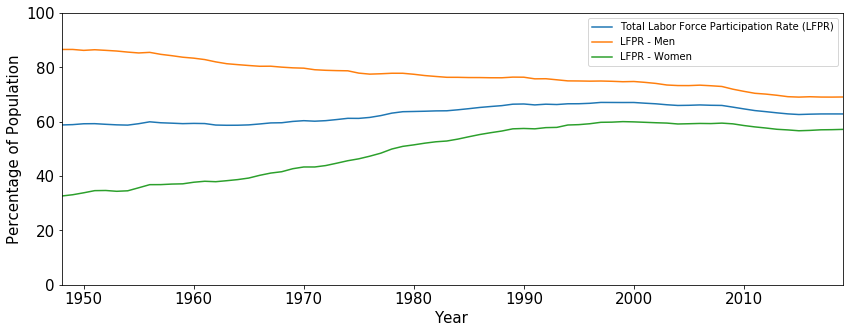

In [21]:
ax_lfpr = lfpr.plot(x="year", figsize=(14,5), ylim=(0,100), fontsize=15)
ax_lfpr.set_ylabel("Percentage of Population", size=15)
ax_lfpr.set_xlabel("Year", size=15)

## Plot Notes
The above plot does show a steady decline in the labor force participation rate for men throughout the 20th centery. However, this is more than offset by women joining the workforce. By the start of the 21st centery, it appears to me that some sort of equilibrium has occurred. While the number of working men still exceeds the number of working women, the labor force participation rate for both now pretty much tracks together. This contradicts the idea that recent job losses have had a significantly greater impact on men over women.

In [22]:
# Pull in the data for all employees who work in manufacturing
fred_csv_to_sql('data/All Employees - Manufacturing.csv', 'all_empl_mfg', conn)

   year  all_empl_mfg
0  1939   9450.250000
1  1940  10101.583333
2  1941  12127.083333
3  1942  14040.166667
4  1943  16163.250000


In [23]:
# Pull in the data for all employees on nonfarm payrolls. 
# This data series was the closest thing to "everyone with a job" I could find on FRED
fred_csv_to_sql('data/All Employees - Nonfarm.csv', 'all_empl_nonfarm', conn)

   year  all_empl_nonfarm
0  1939      30644.500000
1  1940      32409.500000
2  1941      36609.083333
3  1942      40230.750000
4  1943      42593.416667


In [24]:
# Query the data with a JOIN to show all the time series in one table
all_empl = pd.read_sql_query("""
    SELECT 
        nonfarm.year,
        nonfarm.all_empl_nonfarm AS "All Employees (nonfarm)",
        mfg.all_empl_mfg AS "Manufacturing Employees"
    FROM all_empl_nonfarm AS nonfarm
    INNER JOIN all_empl_mfg AS mfg ON nonfarm.year=mfg.year
""", conn)

all_empl.head(10)

,year,All Employees (nonfarm),Manufacturing Employees
0,1939,30644.500000,9450.250000
1,1940,32409.500000,10101.583333
2,1941,36609.083333,12127.083333
3,1942,40230.750000,14040.166667
4,1943,42593.416667,16163.250000
5,1944,42016.083333,15909.750000
6,1945,40503.500000,14253.750000
7,1946,41736.833333,13504.416667
8,1947,43919.000000,14276.666667
9,1948,44933.750000,14316.500000


Text(0.5, 0, 'Year')

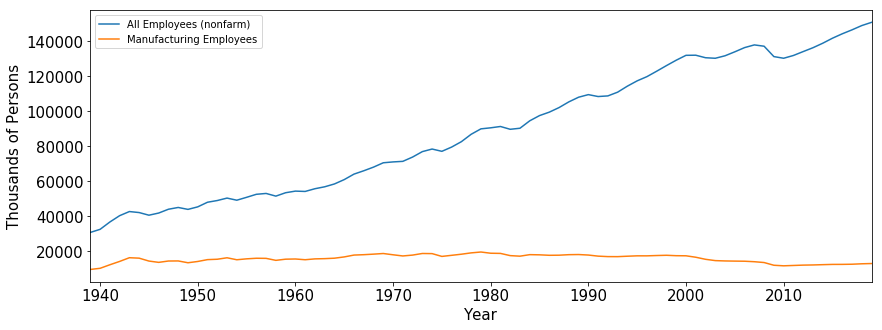

In [25]:
ax_all_empl = all_empl.plot(x="year", figsize=(14,5), fontsize=15)
ax_all_empl.set_ylabel("Thousands of Persons", size=15)
ax_all_empl.set_xlabel("Year", size=15)

## Plot Notes

The above plot shows the number of total nonfarm employees in the workforce alongside total manufacturing workers. It's no shock that a lot more people are working as the years go by, since the population is growing, but here you can see that those new workers are not typically finding their jobs in manufacturing. I think this chart is not particularly informative by itself, since it doesn't show labor force participation alongside manufacturing job losses. To see that, we need to take two more steps below. 1) Turn the above chart into a percentage of all workers who work in manufacturing, and 2) plot that percentage against the percentages from the labor force participation data.

In [26]:
# This function is used in the lambda below to create a new column containing 
# the percentage of all nonfarm employees who work in manufacturing
def total_workers_to_pct_mfg (row):
    return ( row['Manufacturing Employees'] / row['All Employees (nonfarm)'] ) * 100
    
all_empl['Percentage of Employees in Manufacturing'] = all_empl.apply (lambda row: total_workers_to_pct_mfg(row), axis=1)

all_empl.head(10)

,year,All Employees (nonfarm),Manufacturing Employees,Percentage of Employees in Manufacturing
0,1939,30644.500000,9450.250000,30.838323
1,1940,32409.500000,10101.583333,31.168587
2,1941,36609.083333,12127.083333,33.125886
3,1942,40230.750000,14040.166667,34.899093
4,1943,42593.416667,16163.250000,37.947766
5,1944,42016.083333,15909.750000,37.865857
6,1945,40503.500000,14253.750000,35.191403
7,1946,41736.833333,13504.416667,32.356112
8,1947,43919.000000,14276.666667,32.506812
9,1948,44933.750000,14316.500000,31.861351


Text(0.5, 0, 'Year')

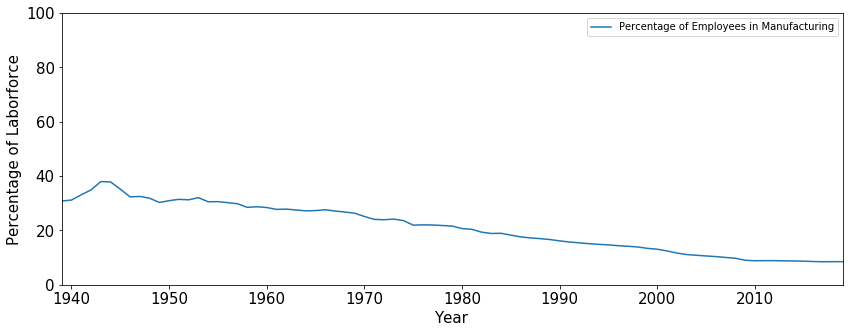

In [27]:
ax_mfg = all_empl.plot(x="year", y="Percentage of Employees in Manufacturing", ylim=(0,100), figsize=(14,5), fontsize=15)
ax_mfg.set_ylabel("Percentage of Laborforce", size=15)
ax_mfg.set_xlabel("Year", size=15)

## Plot Notes

This just shows that first step we talked about: manufacturing workers as a percentage of all workers.

In [28]:
lfpr["Percentage of All Employees Who Work in Manufacturing"] = all_empl['Percentage of Employees in Manufacturing']
lfpr.head(5)

,year,Total Labor Force Participation Rate (LFPR),LFPR - Men,LFPR - Women,Percentage of All Employees Who Work in Manufacturing
0,1948,58.808333,86.583333,32.666667,30.838323
1,1949,58.933333,86.591667,33.133333,31.168587
2,1950,59.250000,86.250000,33.850000,33.125886
3,1951,59.283333,86.483333,34.641667,34.899093
4,1952,59.050000,86.258333,34.700000,37.947766


Text(0.5, 0, 'Year')

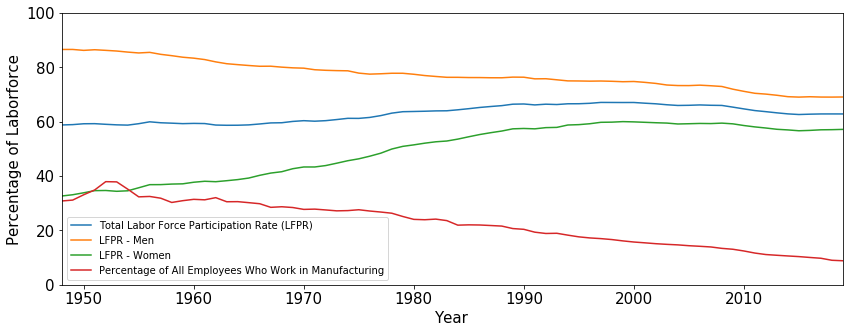

In [29]:
ax_lf_mfg = lfpr.plot(x="year", figsize=(14,5), ylim=(0,100), fontsize=15)
ax_lf_mfg.set_ylabel("Percentage of Laborforce", size=15)
ax_lf_mfg.set_xlabel("Year", size=15)

## Plot notes

This is the final chart I was looking for. This should help to answer the question of whether declines in manufacturing jobs has had a large impact on the labor force participation rate (LFPR), and whether it has had a larger impact on men than women.

Just based on other articles I referenced, it does seem likely that automation in manufacturing has had some impact on a reduction in the LFPR. However, when I look at this chart I find it hard to believe that it is a crisis, yet. Manufacturing jobs as a share of all jobs has been declining for a long time, with apparently little impact on a LFPR that was rising overall. You can clearly see the impact of the last recession across all plot lines, but it doesn't seem to have impacted men dramatically more than women.

Text(0.5, 0, 'Year')

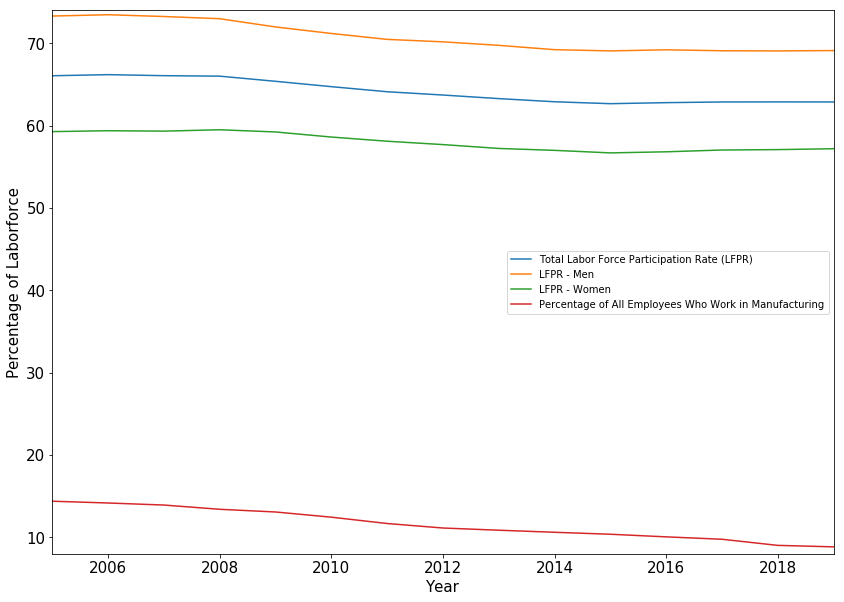

In [30]:
# Show the same plot as above, but change the figsize, xlim and ylim so we can see a little more detail
ax_lf_mfg_2 = lfpr.plot(x="year", figsize=(14,10), xlim=(2005,2019), ylim=(8,74), fontsize=15)
ax_lf_mfg_2.set_ylabel("Percentage of Laborforce", size=15)
ax_lf_mfg_2.set_xlabel("Year", size=15)

## Plot Notes

This plot is the same as above, just a little taller and "zoomed in" to focus on the years since the last recession. The recession clearly had a broad impact here, but manufacturing jobs have continued to go down during the recovery, while the LFPR has even started to tick back up for both men and women.